# Assignment 5

Deadline: 11.06.2025 12:00 CEST

## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.


In [1]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import ndcg_score

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_selection_jkp_factor_scores
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [2]:
# Load the data
market_data = pd.read_parquet("/Users/tilen/OneDrive/Namizje/QF/SS_2025/Quantitative_Portfolio_Management_with_Python/qpmwp-course/data/market_data.parquet")
#market_data=market_data.reset_index()
#market_data=market_data.set_index('date')
market_data['volatility'] = (
    market_data.groupby('id')['price']
    .rolling(window=30)  # 30-day rolling window
    .std()               # Calculate standard deviation
    .reset_index(level=0, drop=True)  # Align with the original index
).fillna(0)  # Fill NaN values with 0

jkp_data = pd.read_parquet("/Users/tilen/OneDrive/Namizje/QF/SS_2025/Quantitative_Portfolio_Management_with_Python/qpmwp-course/data/jkp_data.parquet")
msci_data = pd.read_csv("/Users/tilen/OneDrive/Namizje/QF/SS_2025/Quantitative_Portfolio_Management_with_Python/qpmwp-course/data/msci_country_indices.csv")
print(market_data)
#print(jkp_data.head())
#print(msci_data.head())
print(market_data.columns)

                     price        mktcap  liquidity sector  volatility
date       id                                                         
1999-05-06 1    461.000000  1.235952e+09   129080.0   None    0.000000
1999-05-07 1    455.000000  1.219866e+09     4550.0   None    0.000000
1999-05-10 1    455.000000  1.219866e+09      910.0   None    0.000000
1999-05-11 1    460.000000  1.233271e+09     4600.0   None    0.000000
1999-05-12 1    460.000000  1.233271e+09      460.0   None    0.000000
...                    ...           ...        ...    ...         ...
2024-04-24 313    9.814924  2.016783e+07        0.0   None    2.389009
2024-04-25 313    9.814924  2.016783e+07        0.0   None    2.363978
2024-04-26 313    9.814924  2.016783e+07        0.0   None    2.338206
2024-04-29 313   10.905471  2.240870e+07     2000.0   None    2.298264
2024-04-30 313   10.905471  2.240870e+07        0.0   None    2.255429

[1434082 rows x 5 columns]
Index(['price', 'mktcap', 'liquidity', 'sector', 

In [3]:
# Selection
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path='../data/')
#s=SelectionItemBuilder()

In [4]:
# --------------------------------------------------------------------------
# Prepare backtest service
# --------------------------------------------------------------------------

# Parameters (used more than once below)
expected_return = ExpectedReturn(method = 'geometric')
covariance = Covariance(method = 'pearson')
risk_aversion = 1
solver_name = 'cvxopt'


# Define rebalancing dates
n_days = 21*3  # Rebalance every n_days
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2005-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [5]:
def bibfn_selection_momentum(bs, rebdate: str, **kwargs) -> pd.DataFrame:

    '''
    Backtest item builder function for defining the selection
    Filter stocks based on momentum (i.e., selects past winners).
    '''

    # Arguments
    width = kwargs.get('width', 365)
    agg_fn = kwargs.get('agg_fn', np.prod)
    min_momentum = kwargs.get('min_momentum', 0.03)

    # Return data
    returns = (
        bs.data.get_return_series(
            end_date=rebdate,
            width=width
        ).fillna(0)
    )

    returns2 = returns.copy()
    returns2 = 1 + returns

    returns_agg = returns2.apply(agg_fn, axis=0)

    # Filtering
    return_binary = pd.Series(1, index=returns.columns, dtype=int, name='binary')
    return_binary.loc[returns_agg < min_momentum] = 0


    # Output
    filter_values = pd.DataFrame({
        'values': returns_agg,
        'binary': return_binary,
    }, index=returns_agg.index)

    return filter_values

def bibfn_selection_quality(bs: 'BacktestService', rebdate: str, **kwargs) -> pd.Series:

    """

    Filters stocks based on quality metrics from jkp_data.

    """

    fields = kwargs.get('fields', ['be_me', 'ocf_at', 'ni_be'])

    min_quality_score = kwargs.get('min_quality_score', 0.5)


    # Get jkp_data

    jkp_data = bs.data.jkp_data


    # Filter jkp_data for the given rebalancing date

    jkp_data_date = jkp_data[jkp_data.index.get_level_values('date') == rebdate]


    # Calculate a quality score based on the provided fields

    quality_score = jkp_data_date[fields].mean(axis=1)


    # Select stocks that meet the minimum quality score threshold

    selected_stocks = quality_score[quality_score >= min_quality_score].index.tolist()


    # Create a binary series indicating the selected stocks

    binary_selection = pd.Series(1, index=jkp_data['id'].unique(), name='binary', dtype=int)

    binary_selection[~binary_selection.index.isin(selected_stocks)] = 0


    return binary_selection

In [6]:
def bibfn_selection_volatility(bs, rebdate: str, **kwargs) -> pd.DataFrame:

    '''
    Backtest item builder function for defining the selection
    Filter stocks based on max volatility.
    '''

    # Arguments
    width = kwargs.get('width', 365)
    agg_fn = kwargs.get('agg_fn', np.mean)
    max_volume = kwargs.get('max_volatility', 0.2)

    # Volume data
    volatilty = (
        bs.data.get_volatility_series(
            end_date=rebdate,
            width=width
        ).fillna(0)
    )
    volatility_agg = volatilty.apply(agg_fn, axis=0)

    # Filtering
    vol_binary = pd.Series(1, index=volatilty.columns, dtype=int, name='binary')
    vol_binary.loc[volatility_agg < max_volume] = 0


    # Output
    filter_values = pd.DataFrame({
        'values': volatility_agg,
        'binary': vol_binary,
    }, index=volatility_agg.index)

    return filter_values

In [7]:
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10  # filter out stocks which have not been traded for more than 'n_days' consecutive days
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,   # filter stocks which are illiquid
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
    'quality': SelectionItemBuilder(
        bibfn = bibfn_selection_jkp_factor_scores,
        fields = ['be_me'],
        min_quality_score = 0.5,
    ),
    'momentum': SelectionItemBuilder(
        bibfn = bibfn_selection_momentum,
        width = 252,
        min_momentum = 0.05,
    ),
    'volatility': SelectionItemBuilder(
        bibfn = bibfn_selection_volatility,
        max_volatility = 0.20,
    )
}

In [8]:
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}


In [9]:
# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)


In [10]:
# --------------------------------------------------------------------------
# Run backtest: Mean-Variance
# --------------------------------------------------------------------------

# Update the backtest service with a MeanVariance optimization object
bs.optimization = MeanVariance(
    covariance = covariance,
    expected_return = expected_return,
    risk_aversion = risk_aversion,
    solver_name = solver_name,
)

# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)


Rebalancing date: 2005-01-03
Rebalancing date: 2005-03-31
Rebalancing date: 2005-06-28
Rebalancing date: 2005-09-23
Rebalancing date: 2005-12-21
Rebalancing date: 2006-03-20
Rebalancing date: 2006-06-15
Rebalancing date: 2006-09-12
Rebalancing date: 2006-12-08
Rebalancing date: 2007-03-08
Rebalancing date: 2007-06-05
Rebalancing date: 2007-08-31
Rebalancing date: 2007-11-28
Rebalancing date: 2008-02-26
Rebalancing date: 2008-05-23
Rebalancing date: 2008-08-20
Rebalancing date: 2008-11-17
Rebalancing date: 2009-02-13
Rebalancing date: 2009-05-13
Rebalancing date: 2009-08-10
Rebalancing date: 2009-11-05
Rebalancing date: 2010-02-03
Rebalancing date: 2010-05-03
Rebalancing date: 2010-07-29
Rebalancing date: 2010-10-26
Rebalancing date: 2011-01-21
Rebalancing date: 2011-04-20
Rebalancing date: 2011-07-18
Rebalancing date: 2011-10-13
Rebalancing date: 2012-01-10
Rebalancing date: 2012-04-06
Rebalancing date: 2012-07-04
Rebalancing date: 2012-10-01
Rebalancing date: 2012-12-27
Rebalancing da

c:\Users\tilen\OneDrive\Namizje\QF\SS_2025\Quantitative_Portfolio_Management_with_Python\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Users\tilen\OneDrive\Namizje\QF\SS_2025\Quantitative_Portfolio_Management_with_Python\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Cumulative Performance'}>

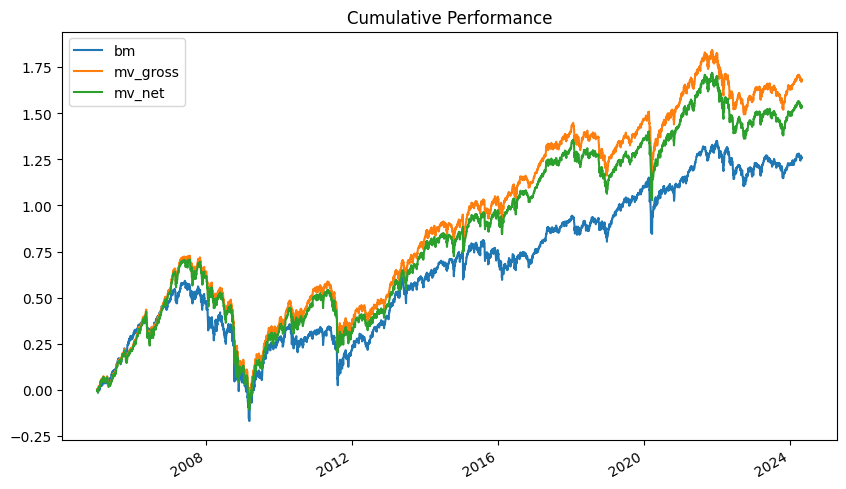

In [11]:
# fixed_costs = 0.01
fixed_costs = 0
variable_costs = 0.004
return_series = bs.data.get_return_series()

strategy_dict = {
    'mv': bt_mv.strategy
}

sim_dict_gross = {
    f'{key}_gross': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=0,
    )
    for key, value in strategy_dict.items()
}
sim_dict_net = {
    f'{key}_net': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    )
    for key, value in strategy_dict.items()
}


sim = pd.concat({
    'bm': bs.data.bm_series,
    **sim_dict_gross,
    **sim_dict_net,
}, axis = 1).dropna()




np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))


In [12]:
import empyrical as ep


# Compute individual performance metrics for each simulated strategy using empyrical
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['bm'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd])

,bm,mv_gross,mv_net
Annual Return,0.064875,0.087495,0.079728
Cumulative Return,2.512737,4.347058,3.633277
Annual Volatility,0.158340,0.152291,0.152217
Sharpe Ratio,0.476372,0.627308,0.580433
Max Drawdown,-0.532487,-0.551998,-0.557139
